# Eight schools models

This notebook explains how to use the classic Eight schools example from [1]. This model was used to determine the effects of coaching on SATS scores in 8 schools. This model is hierarchical and takes the form,

$\mu\sim\mathcal{N}(0, 5),$

$\tau\sim\text{half-Cauchy}(0, 5),$

$\theta_j\sim\mathcal{N}(\mu,\tau),$

$y_j\sim\mathcal{N}(\theta_j,\sigma_j)$,

where $\theta_j$ are the school-level mean scores, $\mu$ and $\tau$ are the population-level mean and standard deviation, $\sigma_j$ are known school-level standard deviations, and $y_j$ are the recorded scores.

This notebook actually covers two sister parameterisations of the above statistical model. The simplest, which mirrors the above statistical model exactly, is known as the "centered" parameterisation. The "non-centered" version introduces auxillary variables, $\bar\theta_j$, such that the joint distribution $p(\mu,\tau,\theta|y)$ remains unchanged but is easier to sample from. It does this by rewriting the middle two expressions above as,

$\bar\theta_j \sim\mathcal{N}(0, 1),$

$\theta_j = \mu + \tau \bar\theta_j.$

[1] "Bayesian data analysis", 3rd edition, 2014, Gelman, A et al..

## Centered model

All of $\sigma_j$ and $y_j$ for $j=1,...,8$ are provided as data that accompany this model. 

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

# Create log pdf
model = pints.toy.EightSchoolsCenteredLogPDF()

# get data
y_j, sigma_j = model.data()

print('y_j = ' + str(y_j))
print('sigma_j = ' + str(sigma_j))

y_j = [28, 8, -3, 7, -1, 1, 18, 12]
sigma_j = [15, 10, 16, 11, 9, 11, 10, 18]


Setting all $\theta_j=4$, we can plot the joint distribution of $(\mu, \tau)$ and can see a funnel shape reminiscient of [Neal's funnel](distribution-neals-funnel.ipynb); perhaps hinting that sampling from this model may be tricky.

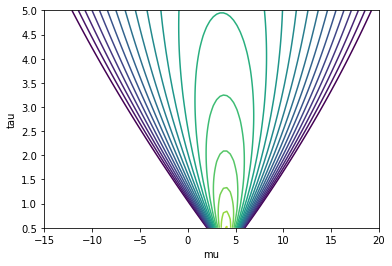

In [2]:
# Plot marginal density
theta_j = (4 * np.ones(8)).tolist()
levels = np.linspace(-100, -30, 20)
mu = np.linspace(-15, 20, 100)
tau = np.linspace(0.5, 5, 100)
X, Y = np.meshgrid(mu, tau)
Z = [[model([i, j] + theta_j) for i in mu] for j in tau]
plt.contour(X, Y, Z, levels)
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()

We can also plot the marginal density of $(\mu,\theta_1)$ and see some correlation between the two dimensions.

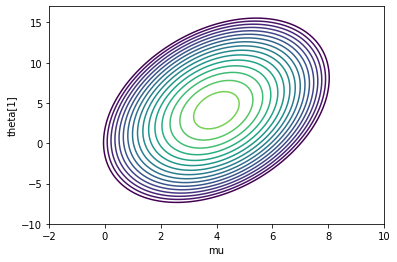

In [3]:
# Plot marginal density
theta_j = (4 * np.ones(7)).tolist()
levels = np.linspace(-100, -30, 20)
mu = np.linspace(-2, 10, 100)
theta_1 = np.linspace(-10, 17, 100)
X, Y = np.meshgrid(mu, theta_1)
Z = [[model([i, 1, j] + theta_j) for i in mu] for j in theta_1]
plt.contour(X, Y, Z, levels)
plt.xlabel('mu')
plt.ylabel('theta[1]')
plt.show()

Since this model comes with gradients, we can use Hamiltonian Monte Carlo to sample from the posterior.

In [4]:
v, dp = model.evaluateS1([3, 1, 3] + theta_j)
len(dp)
model.n_parameters()

10

In [11]:
xs = [np.random.normal(0, 1, size=model.n_parameters())]
xs[0][1] = 1
mcmc = pints.MCMCController(model, 1, xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     21     0.333      0:00.0
2     41     0.25       0:00.0
3     61     0.2        0:00.0
100   2001   0.608      0:00.8
200   4001   0.391      0:01.5
300   6001   0.361      0:02.3
400   8001   0.363      0:03.1
500   10001  0.436255   0:03.8
600   12001  0.465      0:04.6
700   14001  0.460114   0:05.4
800   16001  0.418      0:06.2
900   18001  0.383592   0:06.9
1000  20001  0.39       0:07.7
1100  22001  0.421      0:08.4
1200  24001  0.442      0:09.2
1300  26001  0.468      0:10.0
1400  28001  0.474      0:10.7
1500  30001  0.481      0:11.5
1600  32001  0.482      0:12.2
1700  34001  0.46651    0:13.0
1800  36001  0.445      0:13.7
1900  38001  0.426      0:14.5
2000  40001  0.419      0:15.3
2100  42001  0.425785   0:16.0
2200  44001  0.417      0:16.8
2300  46001  0.422      0:17.6
2400  48001  0.437552   0:18.4
2500  50001

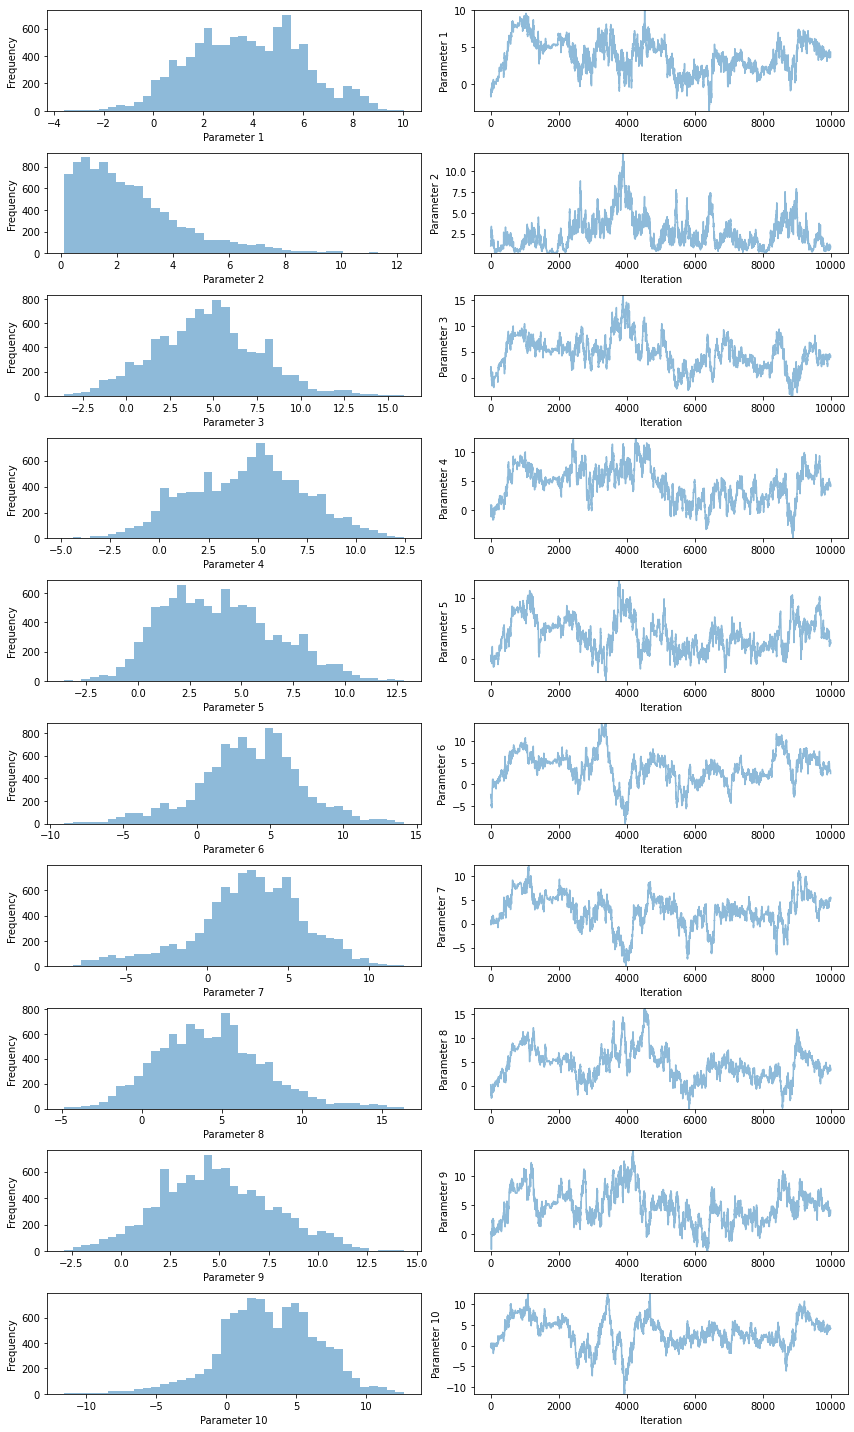

In [12]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()